<span style="color: rgb(112, 112, 112);">in the name of God</sapn>

---

# <span style="color: rgb(112, 112, 112);">**Task 3: LLM for MCQs**</sapn>

# <span style="color: rgb(85, 186, 226);">**Hugging face access token**</sapn>

In [ ]:
from huggingface_hub import login

login(token="Enter")

# <span style="color: rgb(85, 186, 226);">**Loading the dataset**</sapn>

In [7]:
from datasets import load_dataset
import pandas as pd

swag_dataset = load_dataset('swag')

# <span style="color: rgb(85, 186, 226);">**Analyse the dataset**</sapn>

In [27]:
train_df = swag_dataset.get('train').to_pandas()
valid_df = swag_dataset.get('validation').to_pandas()
test_df = swag_dataset.get('test').to_pandas()
df = pd.concat([train_df, valid_df, test_df])

In [28]:
print(f"train set size: {len(train_df)/1000}k")
print(f"validation set size: {len(valid_df)/1000}k")
print(f"test set size: {len(test_df)/1000}k")

train set size: 73.546k
validation set size: 20.006k
test set size: 20.005k


In [60]:
df.head()

,video-id,fold-ind,startphrase,sent1,sent2,gold-source,ending0,ending1,ending2,ending3,label
0,anetv_jkn6uvmqwh4,3416,Members of the procession walk down the street...,Members of the procession walk down the street...,A drum line,gold,passes by walking down the street playing thei...,has heard approaching them.,arrives and they're outside dancing and asleep.,turns the lead singer watches the performance.,0
1,anetv_jkn6uvmqwh4,3417,A drum line passes by walking down the street ...,A drum line passes by walking down the street ...,Members of the procession,gen,are playing ping pong and celebrating one left...,wait slowly towards the cadets.,continues to play as well along the crowd alon...,"continue to play marching, interspersed.",3
2,anetv_jkn6uvmqwh4,3415,A group of members in green uniforms walks wav...,A group of members in green uniforms walks wav...,Members of the procession,gold,pay the other coaches to cheer as people this ...,walk down the street holding small horn brass ...,is seen in the background.,are talking a couple of people playing a game ...,1
3,anetv_jkn6uvmqwh4,3417,A drum line passes by walking down the street ...,A drum line passes by walking down the street ...,Members of the procession,gen,are playing ping pong and celebrating one left...,wait slowly towards the cadets.,makes a square call and ends by jumping down i...,play and go back and forth hitting the drums w...,3
4,anetv_Bri_myFFu4A,2408,The person plays a song on the violin. The man,The person plays a song on the violin.,The man,gold,finishes the song and lowers the instrument.,hits the saxophone and demonstrates how to pro...,finishes massage the instrument again and cont...,continues dancing while the man gore the music...,0


In [61]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 113557 entries, 0 to 20004
Data columns (total 11 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   video-id     113557 non-null  object
 1   fold-ind     113557 non-null  object
 2   startphrase  113557 non-null  object
 3   sent1        113557 non-null  object
 4   sent2        113557 non-null  object
 5   gold-source  113557 non-null  object
 6   ending0      113557 non-null  object
 7   ending1      113557 non-null  object
 8   ending2      113557 non-null  object
 9   ending3      113557 non-null  object
 10  label        113557 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 10.4+ MB


In [62]:
df.isnull().sum()

video-id       0
fold-ind       0
startphrase    0
sent1          0
sent2          0
gold-source    0
ending0        0
ending1        0
ending2        0
ending3        0
label          0
dtype: int64

In [63]:
df.duplicated().sum()

0

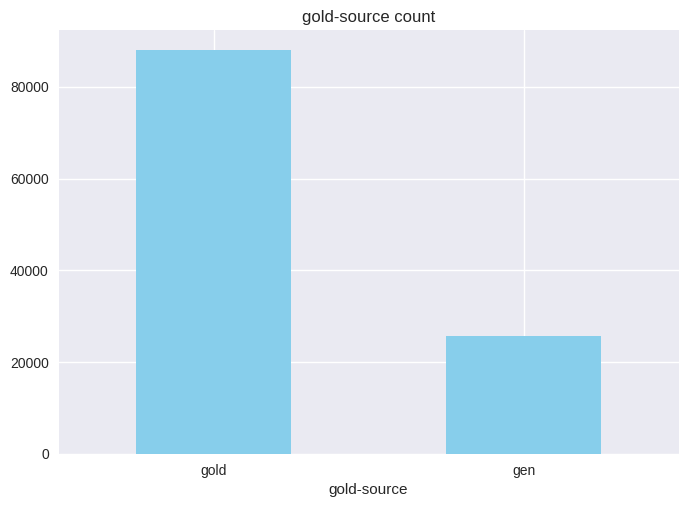

In [64]:
import matplotlib.pyplot as plt
plt.style.use("seaborn-v0_8")

source_count = df['gold-source'].value_counts()

source_count.plot(kind='bar', title='gold-source count', color='skyblue')
plt.xticks(rotation=0)
plt.show()

In [65]:
df_v2 = df.copy()
df_v2['len_sent1'] = df_v2['sent1'].apply(lambda x: len(x.split()))
df_v2['len_sent2'] = df_v2['sent2'].apply(lambda x: len(x.split()))
df_v2['len_end0'] = df_v2['ending0'].apply(lambda x: len(x.split()))
df_v2['len_end1'] = df_v2['ending1'].apply(lambda x: len(x.split()))
df_v2['len_end2'] = df_v2['ending2'].apply(lambda x: len(x.split()))
df_v2['len_end3'] = df_v2['ending3'].apply(lambda x: len(x.split()))

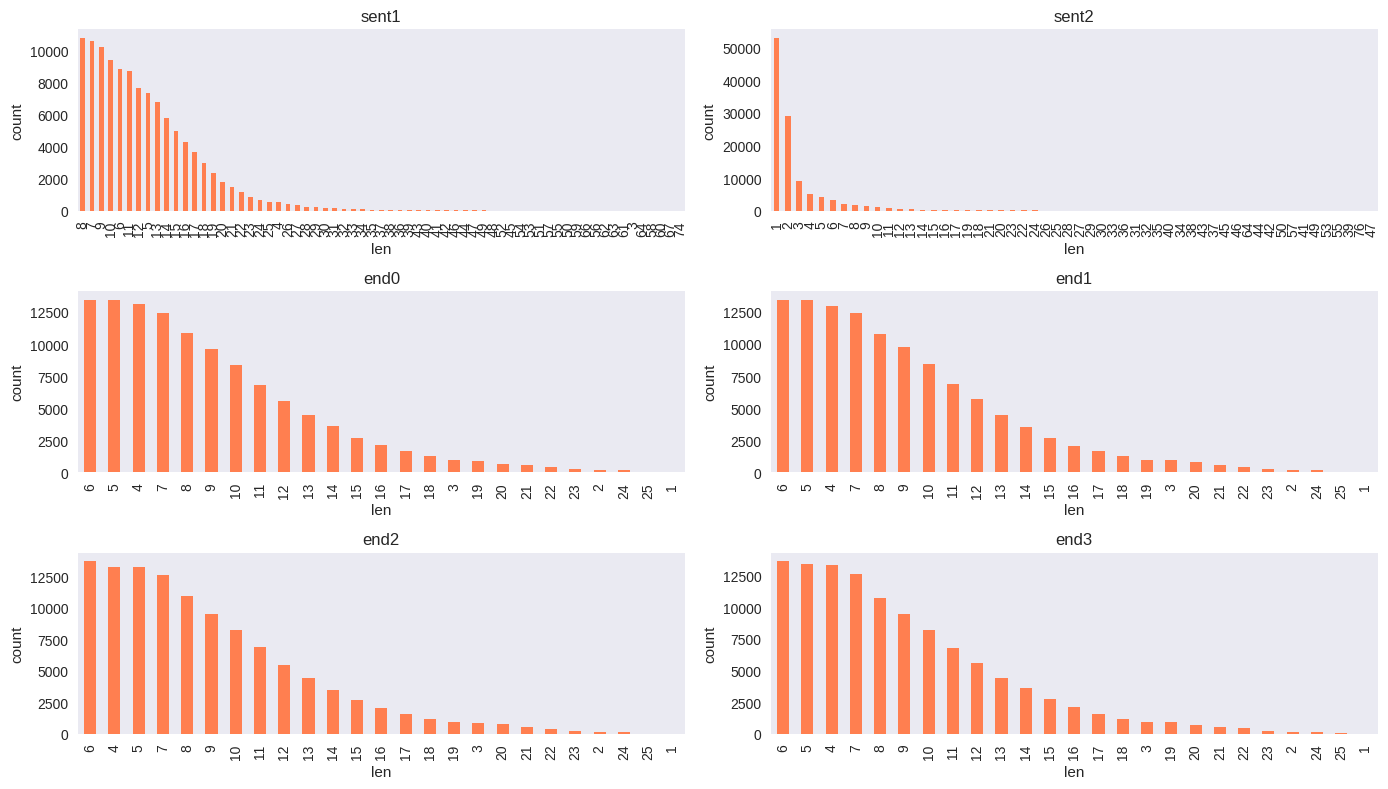

In [66]:
len_columns = ['len_sent1', 'len_sent2', 'len_end0', 'len_end1', 'len_end2', 'len_end3']

plt.figure(figsize=(14, 8))

for i, col in enumerate(len_columns, 1):
    plt.subplot(3, 2, i)
    ax = df_v2[col].value_counts().plot(kind='bar', color='coral', grid=False)
    plt.title(col.split('_')[1])
    plt.xlabel('len')
    plt.ylabel('count')

plt.tight_layout()
plt.show()

In [ ]:
df_v2[len_columns].describe()

,len_sent1,len_sent2,len_end0,len_end1,len_end2,len_end3
count,113557.000000,113557.000000,113557.000000,113557.000000,113557.000000,113557.000000
mean,11.538082,2.700617,8.667119,8.690068,8.660320,8.651461
std,5.382825,3.147949,4.009486,4.021567,4.018033,4.018416
min,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,8.000000,1.000000,6.000000,6.000000,6.000000,6.000000
50%,10.000000,2.000000,8.000000,8.000000,8.000000,8.000000
75%,14.000000,3.000000,11.000000,11.000000,11.000000,11.000000
max,74.000000,76.000000,25.000000,25.000000,25.000000,25.000000


# <span style="color:rgb(85, 186, 226);">**Preprocess the dataset**</sapn>

In [22]:
def preprocess(batch: dict, tokenizer):
    batch_size = len(batch['sent1'])
    all_candidates = []
    for i in range(batch_size):
        full_sentence = batch['sent1'][i] + ' ' + batch['sent2'][i]
        for k in range(4):
            candidate = full_sentence + ' ' + batch[f"ending{k}"][i]
            all_candidates.append(candidate)
    
    tokenized = tokenizer(all_candidates, return_tensors=None)

    def unflatten(lst):
        return [lst[i*4: (i+1)*4] for i in range(batch_size)]
    
    tokenized = {k: unflatten(v) for k, v in tokenized.items()}

    return tokenized

# <span style="color:rgb(85, 186, 226);">**Load a tokenizer**</sapn>


In [11]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-uncased")

# <span style="color:rgb(85, 186, 226);">**Apply the preprocessing function**</sapn>

In [23]:
train_dataset = swag_dataset['train']

preprocessed_trainset = train_dataset.map(lambda batch: preprocess(batch, tokenizer), batched=True)

Map:   0%|          | 0/73546 [00:00<?, ? examples/s]

# <span style="color:rgb(85, 186, 226);">**Padding**</sapn>

In [ ]:
from transformers import DataCollatorForMultipleChoice

data_collator = DataCollatorForMultipleChoice(tokenizer, padding=True)

# <span style="color:rgb(85, 186, 226);">**Load the model**</sapn>

# <span style="color: rgb(85, 186, 226);">**Test the model on the dataset**</sapn>

# <span style="color: rgb(85, 186, 226);">**Use in-context learning (ICL)**</sapn>

# <span style="color: rgb(85, 186, 226);">**Fine-tune bert**</sapn>

# <span style="color:rgb(85, 186, 226);">**In-Context Learning with the Fine-Tuned Model**</sapn>

# <span style="color:rgb(85, 186, 226);">**Analyse the results**</sapn>

# <span style="color:rgb(238, 65, 65);">**Questions**</sapn>